In [1]:
# Cell 1: Importing Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Clustering imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

# Visualization imports
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Scikit-learn clustering modules loaded")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Scikit-learn clustering modules loaded


In [3]:
# Cell 2: Problem Introduction - Clustering Analysis
# Defining clustering objectives for particle physics data
# Approach: Unsupervised pattern discovery in collision events

print("="*70)
print("TASK D: CLUSTERING ANALYSIS")
print("="*70)

print("\nClustering Objectives:")
print("  1. Discover natural groupings in particle collision events")
print("  2. Identify event patterns beyond binary classification")
print("  3. Understand physics-based event characteristics")
print("  4. Validate clusters against known signal/background labels")

print("\nClustering Approaches:")
print("  - K-Means: Partition-based clustering")
print("  - Hierarchical: Agglomerative clustering")
print("  - DBSCAN: Density-based clustering")

print("\nWhy Clustering for HIGGS Data?")
print("  - Discover sub-categories within signal/background")
print("  - Identify rare event types")
print("  - Understand event topology patterns")
print("  - Validate supervised classification boundaries")

TASK D: CLUSTERING ANALYSIS

Clustering Objectives:
  1. Discover natural groupings in particle collision events
  2. Identify event patterns beyond binary classification
  3. Understand physics-based event characteristics
  4. Validate clusters against known signal/background labels

Clustering Approaches:
  - K-Means: Partition-based clustering
  - Hierarchical: Agglomerative clustering
  - DBSCAN: Density-based clustering

Why Clustering for HIGGS Data?
  - Discover sub-categories within signal/background
  - Identify rare event types
  - Understand event topology patterns
  - Validate supervised classification boundaries


In [6]:
# Cell 3: Loading and Preparing Data for Clustering
# Loading processed data, sampling, and SCALING features
# Feature scaling is critical for distance-based clustering

print("="*70)
print("DATA LOADING & PREPARATION FOR CLUSTERING")
print("="*70)

# Loading processed data
X_full, X_test_full, y_full, y_test_full = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nFull dataset loaded:")
print(f"  Training: {X_full.shape}")
print(f"  Test: {X_test_full.shape}")

# Sampling for computational efficiency
# Clustering on 800K samples is very slow - use representative sample
CLUSTER_SAMPLE_SIZE = 50000  # 50K samples for clustering

print(f"\nSampling {CLUSTER_SAMPLE_SIZE:,} events for clustering analysis")
print("   (Clustering is O(n²) - full dataset would take hours)")

# Stratified sampling to preserve class distribution
from sklearn.model_selection import train_test_split

X_cluster, _, y_cluster, _ = train_test_split(
    X_full, y_full,
    train_size=CLUSTER_SAMPLE_SIZE,
    random_state=SEED_VALUE,
    stratify=y_full
)

print(f"\nClustering Dataset (before scaling):")
print(f"  Shape: {X_cluster.shape}")
print(f"  Features: {X_cluster.shape[1]}")
print(f"  Samples: {X_cluster.shape[0]:,}")

# Feature Scaling for Clustering

print("\n" + "="*70)
print("FEATURE SCALING (CRITICAL FOR DISTANCE-BASED CLUSTERING)")
print("="*70)

print("\nWhy scaling is essential:")
print("  - K-Means uses Euclidean distance")
print("  - Hierarchical clustering uses distance metrics")
print("  - Features have different scales (pT vs angles)")
print("  - Unscaled → larger scale features dominate clustering")

# Storing original for comparison
X_cluster_original = X_cluster.copy()

# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Converting back to DataFrame to preserve column names
X_cluster = pd.DataFrame(
    X_cluster_scaled, 
    columns=X_cluster_original.columns,
    index=X_cluster_original.index
)

print("\nFeatures scaled using StandardScaler")
print(f"  Mean ≈ 0: {X_cluster.mean().mean():.6f}")
print(f"  Std ≈ 1: {X_cluster.std().mean():.4f}")

# Verify scaling
print("\nScaling verification (first 5 features):")
print(f"{'Feature':<30s} {'Original Mean':>15s} {'Scaled Mean':>15s} {'Scaled Std':>12s}")
print("-" * 75)
for col in X_cluster.columns[:5]:
    orig_mean = X_cluster_original[col].mean()
    scaled_mean = X_cluster[col].mean()
    scaled_std = X_cluster[col].std()
    print(f"{col:<30s} {orig_mean:>15.4f} {scaled_mean:>15.6f} {scaled_std:>12.4f}")


print(f"\nClass Distribution (for validation):")
print(f"  Signal (1): {(y_cluster == 1).sum():,} ({(y_cluster == 1).mean()*100:.1f}%)")
print(f"  Background (0): {(y_cluster == 0).sum():,} ({(y_cluster == 0).mean()*100:.1f}%)")

print("\nNote: True labels will be used only for cluster validation, not during clustering (unsupervised learning)")

DATA LOADING & PREPARATION FOR CLUSTERING
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Full dataset loaded:
  Training: (800000, 28)
  Test: (200000, 28)

Sampling 50,000 events for clustering analysis
   (Clustering is O(n²) - full dataset would take hours)

Clustering Dataset (before scaling):
  Shape: (50000, 28)
  Features: 28
  Samples: 50,000

FEATURE SCALING (CRITICAL FOR DISTANCE-BASED CLUSTERING)

Why scaling is essential:
  - K-Means uses Euclidean distance
  - Hierarchical clustering uses distance metrics
  - Features have different scales (pT vs angles)
  - Unscaled → larger scale features dominate clustering

Features scaled using StandardScaler
  Mean ≈ 0: 0.000000
  Std ≈ 1: 1.0000

Scaling verification (first 5 features):
Feature                          Original Mean     Scaled Mean   Scaled Std
---------------------------

DIMENSIONALITY REDUCTION (PCA)

Applying PCA for visualization...
   (PCA applied to SCALED features)

2D PCA:
  Explained variance: 21.60%
  PC1: 14.95%
  PC2: 6.66%

3D PCA:
  Explained variance: 28.00%
  PC1: 14.95%
  PC2: 6.66%
  PC3: 6.39%

Total variance captured by first 10 components:
   59.76%

PCA analysis saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\clustering_pca_analysis.png


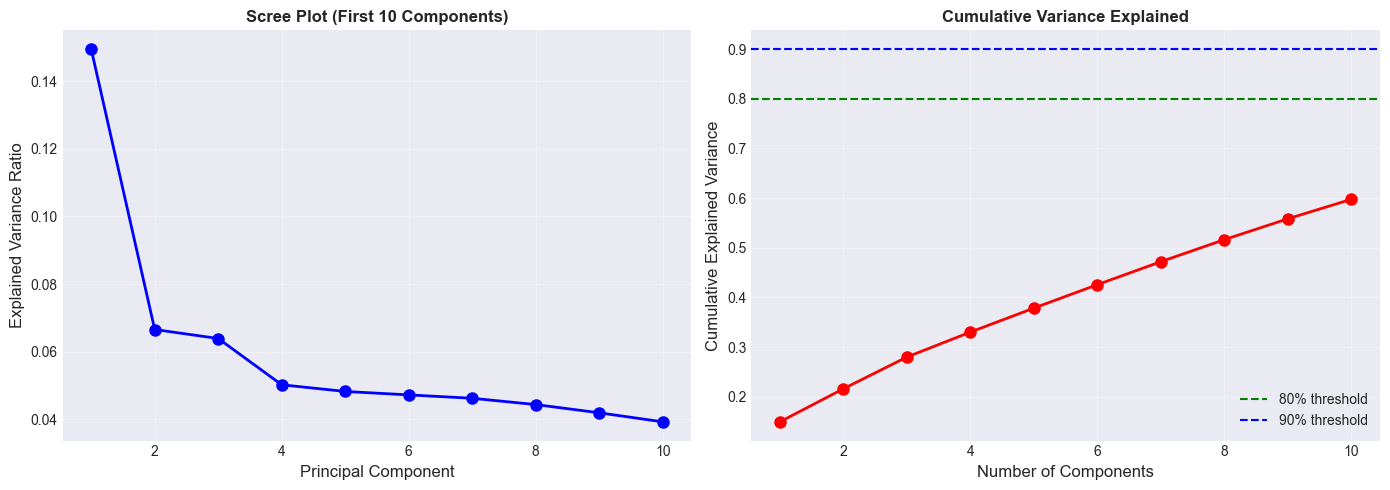

In [8]:
# Cell 4: Dimensionality Reduction - PCA
# Reducing to 2D/3D for visualization while preserving variance
# Using Principal Component Analysis (on SCALED data)

print("="*70)
print("DIMENSIONALITY REDUCTION (PCA)")
print("="*70)

# PCA for visualization (2D and 3D)
print("\nApplying PCA for visualization...")
print("   (PCA applied to SCALED features)")

# 2D PCA
pca_2d = PCA(n_components=2, random_state=SEED_VALUE)
X_pca_2d = pca_2d.fit_transform(X_cluster)

print(f"\n2D PCA:")
print(f"  Explained variance: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")

# 3D PCA
pca_3d = PCA(n_components=3, random_state=SEED_VALUE)
X_pca_3d = pca_3d.fit_transform(X_cluster)

print(f"\n3D PCA:")
print(f"  Explained variance: {pca_3d.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  PC1: {pca_3d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_3d.explained_variance_ratio_[1]*100:.2f}%")
print(f"  PC3: {pca_3d.explained_variance_ratio_[2]*100:.2f}%")

# Full PCA for scree plot
pca_full = PCA(random_state=SEED_VALUE)
pca_full.fit(X_cluster)

print(f"\nTotal variance captured by first 10 components:")
print(f"   {pca_full.explained_variance_ratio_[:10].sum()*100:.2f}%")

# Visualizing PCA variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, 11), pca_full.explained_variance_ratio_[:10], 
            'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (First 10 Components)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_[:10])
axes[1].plot(range(1, 11), cumulative_var, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='b', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

pca_path = FIGURE_OUTPUT / 'clustering_pca_analysis.png'
plt.savefig(pca_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nPCA analysis saved to {pca_path}")

plt.show()

DETERMINING OPTIMAL K (ELBOW METHOD)

Testing K from 2 to 10...
  Testing K=2... Silhouette: 0.2075
  Testing K=3... Silhouette: 0.0428
  Testing K=4... Silhouette: 0.0435
  Testing K=5... Silhouette: 0.0396
  Testing K=6... Silhouette: 0.0419
  Testing K=7... Silhouette: 0.0388
  Testing K=8... Silhouette: 0.0460
  Testing K=9... Silhouette: 0.0473
  Testing K=10... Silhouette: 0.0446

Optimal K by different metrics:
  Silhouette Score: K = 2
  Calinski-Harabasz: K = 2
  Davies-Bouldin: K = 2

Elbow analysis saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\clustering_elbow_analysis.png


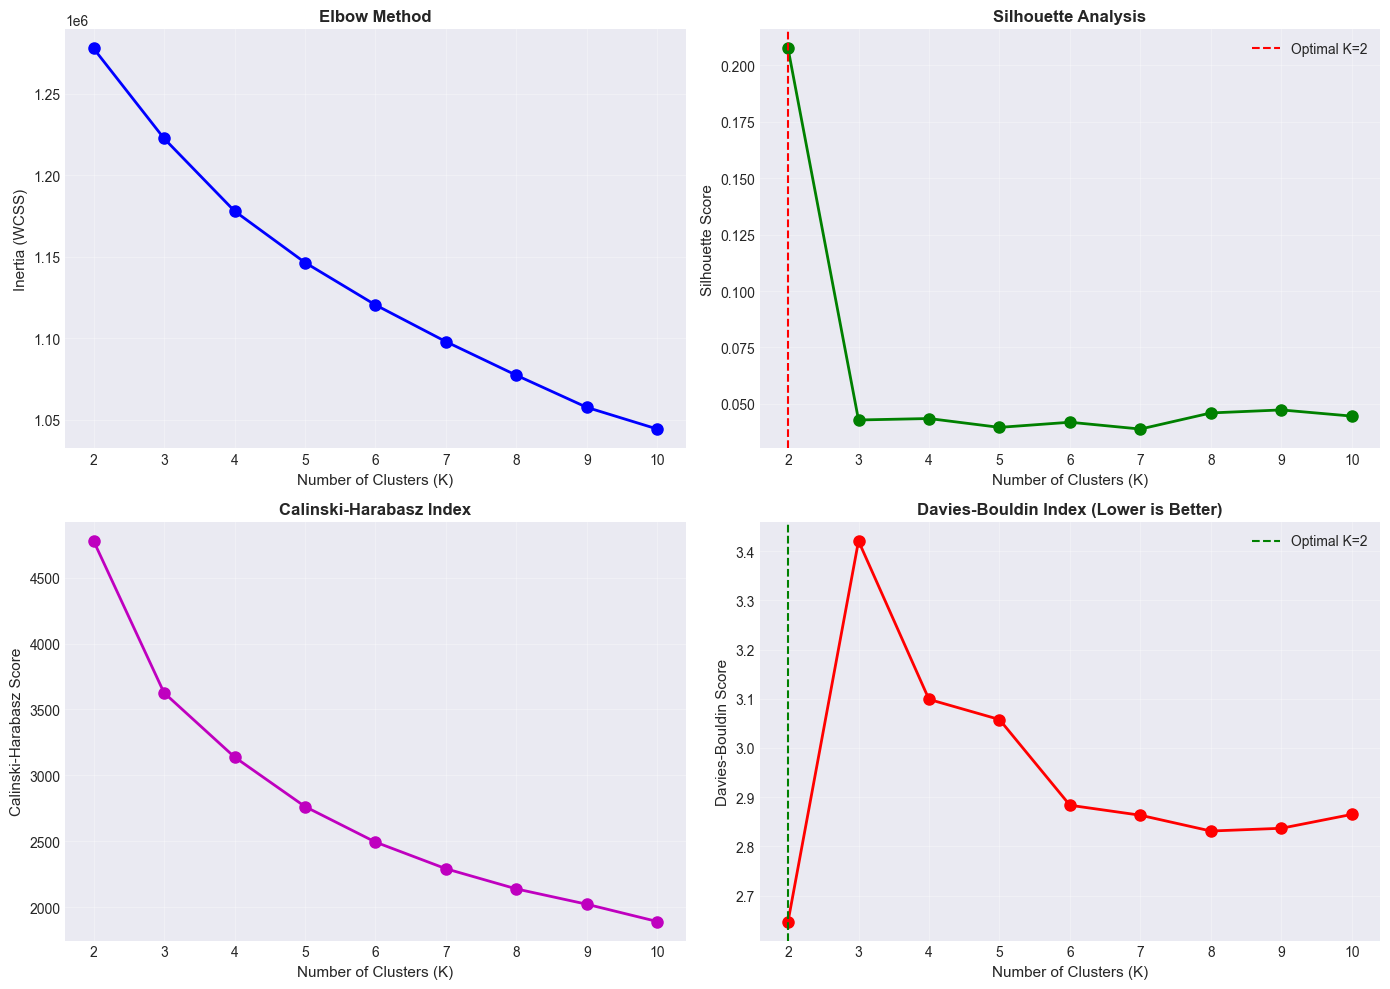


Selected Optimal K = 2 (based on Silhouette Score)


In [9]:
# Cell 5: Determining Optimal K - Elbow Method
# Finding optimal number of clusters for K-Means
# Using Inertia (within-cluster sum of squares) vs K

print("="*70)
print("DETERMINING OPTIMAL K (ELBOW METHOD)")
print("="*70)

print("\nTesting K from 2 to 10...")

# Range of K values to test
k_range = range(2, 11)
inertias = []
silhouettes = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    print(f"  Testing K={k}...", end=' ')
    
    # Fitting K-Means
    kmeans = KMeans(n_clusters=k, random_state=SEED_VALUE, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    
    # Computing metrics
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_cluster, labels))
    calinski_scores.append(calinski_harabasz_score(X_cluster, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_cluster, labels))
    
    print(f"Silhouette: {silhouettes[-1]:.4f}")

# Finding optimal K
optimal_k_silhouette = k_range[np.argmax(silhouettes)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print(f"\nOptimal K by different metrics:")
print(f"  Silhouette Score: K = {optimal_k_silhouette}")
print(f"  Calinski-Harabasz: K = {optimal_k_calinski}")
print(f"  Davies-Bouldin: K = {optimal_k_davies}")

# Visualize elbow method
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Inertia (Elbow)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (WCSS)', fontsize=11)
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Silhouette Score
axes[0, 1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[0, 1].axvline(x=optimal_k_silhouette, color='r', linestyle='--', 
                   label=f'Optimal K={optimal_k_silhouette}')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Calinski-Harabasz
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 0].set_title('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Davies-Bouldin
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 1].axvline(x=optimal_k_davies, color='g', linestyle='--',
                   label=f'Optimal K={optimal_k_davies}')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=11)
axes[1, 1].set_title('Davies-Bouldin Index (Lower is Better)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

elbow_path = FIGURE_OUTPUT / 'clustering_elbow_analysis.png'
plt.savefig(elbow_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nElbow analysis saved to {elbow_path}")

plt.show()

# Selecting optimal K (using silhouette as primary metric)
OPTIMAL_K = optimal_k_silhouette
print(f"\nSelected Optimal K = {OPTIMAL_K} (based on Silhouette Score)")

In [10]:
# Cell 6: K-Means Clustering
# Applying K-Means with optimal K

print("="*70)
print("K-MEANS CLUSTERING")
print("="*70)

print(f"\nApplying K-Means with K={OPTIMAL_K}...")

# Fitting K-Means
kmeans_model = KMeans(n_clusters=OPTIMAL_K, random_state=SEED_VALUE, n_init=10)

start_time = time.time()
kmeans_labels = kmeans_model.fit_predict(X_cluster)
kmeans_time = time.time() - start_time

print(f"Clustering completed in {kmeans_time:.2f} seconds")

# Evaluating clustering
kmeans_silhouette = silhouette_score(X_cluster, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_cluster, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_cluster, kmeans_labels)

print(f"\nK-Means Evaluation Metrics:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f} (closer to 1 is better)")
print(f"  Calinski-Harabasz: {kmeans_calinski:.2f} (higher is better)")
print(f"  Davies-Bouldin: {kmeans_davies:.4f} (lower is better)")
print(f"  Inertia: {kmeans_model.inertia_:.2f}")

# Cluster distribution
print(f"\nCluster Distribution:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    pct = count / len(kmeans_labels) * 100
    print(f"  Cluster {cluster_id}: {count:,} events ({pct:.1f}%)")

# Storing results
clustering_results = {
    'kmeans': {
        'model': kmeans_model,
        'labels': kmeans_labels,
        'silhouette': kmeans_silhouette,
        'calinski': kmeans_calinski,
        'davies_bouldin': kmeans_davies,
        'time': kmeans_time,
        'n_clusters': OPTIMAL_K
    }
}

K-MEANS CLUSTERING

Applying K-Means with K=2...
Clustering completed in 0.19 seconds

K-Means Evaluation Metrics:
  Silhouette Score: 0.2075 (closer to 1 is better)
  Calinski-Harabasz: 4777.51 (higher is better)
  Davies-Bouldin: 2.6471 (lower is better)
  Inertia: 1277892.66

Cluster Distribution:
  Cluster 0: 8,629 events (17.3%)
  Cluster 1: 41,371 events (82.7%)


HIERARCHICAL CLUSTERING

Applying Agglomerative Clustering with K=2...
Clustering completed in 359.09 seconds

Hierarchical Clustering Evaluation Metrics:
  Silhouette Score: 0.1206
  Calinski-Harabasz: 3067.40
  Davies-Bouldin: 3.6573

Cluster Distribution:
Cluster 0: 13,150 events (26.3%)
Cluster 1: 36,850 events (73.7%)

Generating dendrogram (using 1000-sample subset)...
Dendrogram saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\clustering_dendrogram.png


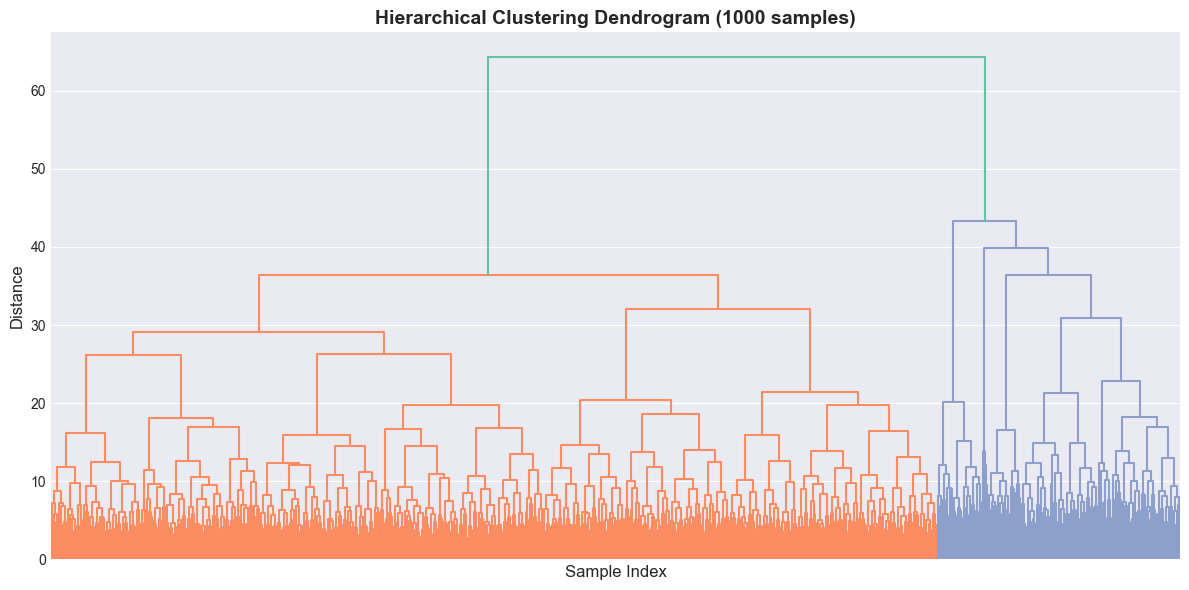

In [11]:
# Cell 7: Hierarchical Clustering
# Applying Agglomerative Hierarchical Clustering
# Using Ward linkage with optimal K from elbow analysis

print("="*70)
print("HIERARCHICAL CLUSTERING")
print("="*70)

print(f"\nApplying Agglomerative Clustering with K={OPTIMAL_K}...")

# Fitting Hierarchical Clustering
hierarchical_model = AgglomerativeClustering(
    n_clusters=OPTIMAL_K,
    linkage='ward'
)

start_time = time.time()
hierarchical_labels = hierarchical_model.fit_predict(X_cluster)
hierarchical_time = time.time() - start_time

print(f"Clustering completed in {hierarchical_time:.2f} seconds")

# Evaluating clustering
hierarchical_silhouette = silhouette_score(X_cluster, hierarchical_labels)
hierarchical_calinski = calinski_harabasz_score(X_cluster, hierarchical_labels)
hierarchical_davies = davies_bouldin_score(X_cluster, hierarchical_labels)

print(f"\nHierarchical Clustering Evaluation Metrics:")
print(f"  Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"  Calinski-Harabasz: {hierarchical_calinski:.2f}")
print(f"  Davies-Bouldin: {hierarchical_davies:.4f}")

# Cluster distribution
print(f"\nCluster Distribution:")
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    pct = count / len(hierarchical_labels) * 100
    print(f"Cluster {cluster_id}: {count:,} events ({pct:.1f}%)")

# Storing results
clustering_results['hierarchical'] = {
    'model': hierarchical_model,
    'labels': hierarchical_labels,
    'silhouette': hierarchical_silhouette,
    'calinski': hierarchical_calinski,
    'davies_bouldin': hierarchical_davies,
    'time': hierarchical_time,
    'n_clusters': OPTIMAL_K
}

# Dendrogram (using sample for visualization)
print("\nGenerating dendrogram (using 1000-sample subset)...")

# Sample for dendrogram (full dataset is too large)
sample_size = 1000
sample_idx = np.random.choice(len(X_cluster), sample_size, replace=False)
X_sample = X_cluster.iloc[sample_idx]

# Computing linkage
linkage_matrix = linkage(X_sample, method='ward')

# Plotting dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(linkage_matrix, ax=ax, no_labels=True)
ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
ax.set_title(f'Hierarchical Clustering Dendrogram (1000 samples)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()

dendrogram_path = FIGURE_OUTPUT / 'clustering_dendrogram.png'
plt.savefig(dendrogram_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Dendrogram saved to {dendrogram_path}")

plt.show()

DBSCAN CLUSTERING (Density-Based)

Determining DBSCAN parameters...
K-distance graph saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\clustering_kdistance.png


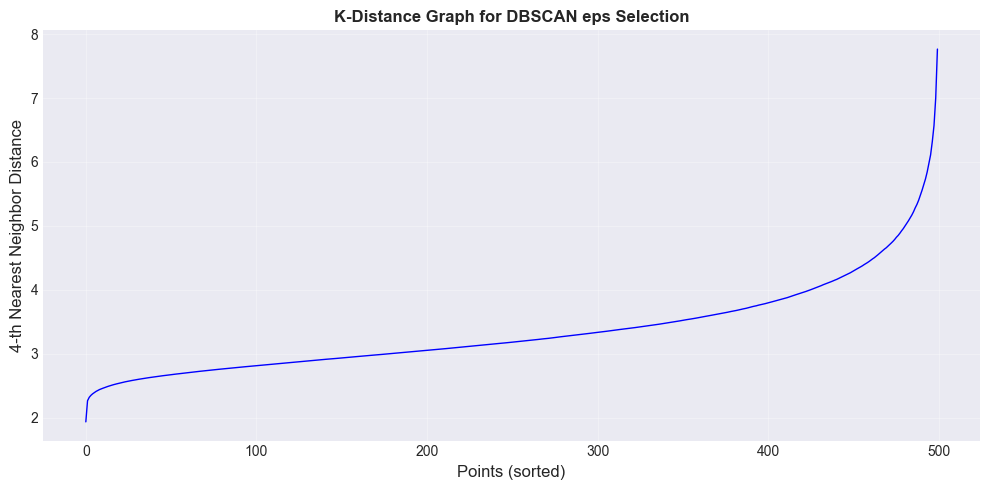

Estimated eps: 4.8222

Applying DBSCAN with eps=4.8222, min_samples=5...
Clustering completed in 7.63 seconds

DBSCAN Results:
  Clusters found: 1
  Noise points: 1,518 (3.0%)

Insufficient clusters found for evaluation

Cluster Distribution:
Noise: 1,518 events (3.0%)
Cluster 0: 48,482 events (97.0%)


In [13]:
# Cell 8: DBSCAN Clustering
# Density-based clustering to find arbitrary-shaped clusters
# Using DBSCAN with epsilon and min_samples tuning
# ============================================================================

print("="*70)
print("DBSCAN CLUSTERING (Density-Based)")
print("="*70)

print("\nDetermining DBSCAN parameters...")

# Finding optimal eps using k-distance graph
# Calculating distances to 4th nearest neighbor
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_cluster)
distances, indices = neighbors.kneighbors(X_cluster)

# Sorting distances
distances = np.sort(distances[:, 4], axis=0)

# Plotting k-distance graph (using sample)
sample_distances = distances[::100]  # Every 100th point

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample_distances, 'b-', linewidth=1)
ax.set_xlabel('Points (sorted)', fontsize=12)
ax.set_ylabel('4-th Nearest Neighbor Distance', fontsize=12)
ax.set_title('K-Distance Graph for DBSCAN eps Selection', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()

kdist_path = FIGURE_OUTPUT / 'clustering_kdistance.png'
plt.savefig(kdist_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"K-distance graph saved to {kdist_path}")

plt.show()

# Estimating eps from elbow in k-distance graph
eps_estimate = np.percentile(distances, 95)  # 95th percentile
print(f"Estimated eps: {eps_estimate:.4f}")

# Applying DBSCAN
print(f"\nApplying DBSCAN with eps={eps_estimate:.4f}, min_samples=5...")

dbscan_model = DBSCAN(eps=eps_estimate, min_samples=5)

start_time = time.time()
dbscan_labels = dbscan_model.fit_predict(X_cluster)
dbscan_time = time.time() - start_time

print(f"Clustering completed in {dbscan_time:.2f} seconds")

# Number of clusters (excluding noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"  Clusters found: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise:,} ({n_noise/len(dbscan_labels)*100:.1f}%)")

if n_clusters_dbscan > 1:
    # Evaluating clustering (excluding noise points)
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_cluster[mask], dbscan_labels[mask])
        dbscan_calinski = calinski_harabasz_score(X_cluster[mask], dbscan_labels[mask])
        dbscan_davies = davies_bouldin_score(X_cluster[mask], dbscan_labels[mask])
        
        print(f"\nDBSCAN Evaluation (excluding noise):")
        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  Calinski-Harabasz: {dbscan_calinski:.2f}")
        print(f"  Davies-Bouldin: {dbscan_davies:.4f}")
    else:
        dbscan_silhouette = dbscan_calinski = dbscan_davies = np.nan
        print("\nAll points classified as noise - cannot compute metrics")
else:
    dbscan_silhouette = dbscan_calinski = dbscan_davies = np.nan
    print("\nInsufficient clusters found for evaluation")

# Cluster distribution
print(f"\nCluster Distribution:")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    if cluster_id == -1:
        print(f"Noise: {count:,} events ({count/len(dbscan_labels)*100:.1f}%)")
    else:
        print(f"Cluster {cluster_id}: {count:,} events ({count/len(dbscan_labels)*100:.1f}%)")

# Storing results
clustering_results['dbscan'] = {
    'model': dbscan_model,
    'labels': dbscan_labels,
    'silhouette': dbscan_silhouette,
    'calinski': dbscan_calinski,
    'davies_bouldin': dbscan_davies,
    'time': dbscan_time,
    'n_clusters': n_clusters_dbscan,
    'n_noise': n_noise
}
